In [31]:
#  import libary
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
df = pd.read_csv("../../datasets/others/sunspot.csv", sep=";",header=None)
df.columns = ['year', 'month', 'day', 'decimal_date', 'total_sunspot_number', 'std_dev', 'num_observation', 'provisional_indicator']

In [33]:
df = df.assign(date=df.year.astype('string')+'-'+df.month.astype('string')+'-'+df.day.astype('string'))

In [34]:
df.index = pd.to_datetime(df.date)

In [35]:
df.head()

,year,month,day,decimal_date,total_sunspot_number,std_dev,num_observation,provisional_indicator,date
date,,,,,,,,,
1818-01-01,1818,1,1,1818.001,-1,-1.0,0,1,1818-1-1
1818-01-02,1818,1,2,1818.004,-1,-1.0,0,1,1818-1-2
1818-01-03,1818,1,3,1818.007,-1,-1.0,0,1,1818-1-3
1818-01-04,1818,1,4,1818.010,-1,-1.0,0,1,1818-1-4
1818-01-05,1818,1,5,1818.012,-1,-1.0,0,1,1818-1-5


In [36]:
df.drop(['year', 'month', 'day', 'date', 'decimal_date'], axis=1, inplace=True)

In [37]:
df.head()

,total_sunspot_number,std_dev,num_observation,provisional_indicator
date,,,,
1818-01-01,-1,-1.0,0,1
1818-01-02,-1,-1.0,0,1
1818-01-03,-1,-1.0,0,1
1818-01-04,-1,-1.0,0,1
1818-01-05,-1,-1.0,0,1


<AxesSubplot:>

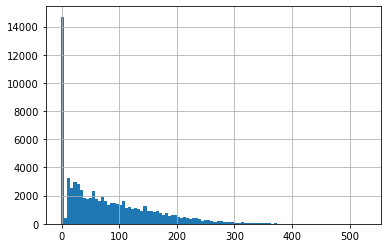

In [38]:
df.total_sunspot_number.hist(bins=100)

In [39]:
df.total_sunspot_number.value_counts()

 0      11347
-1       3247
 12      1319
 27       922
 23       921
        ...  
 484        1
 356        1
 463        1
 518        1
 335        1
Name: total_sunspot_number, Length: 438, dtype: int64

<AxesSubplot:xlabel='date'>

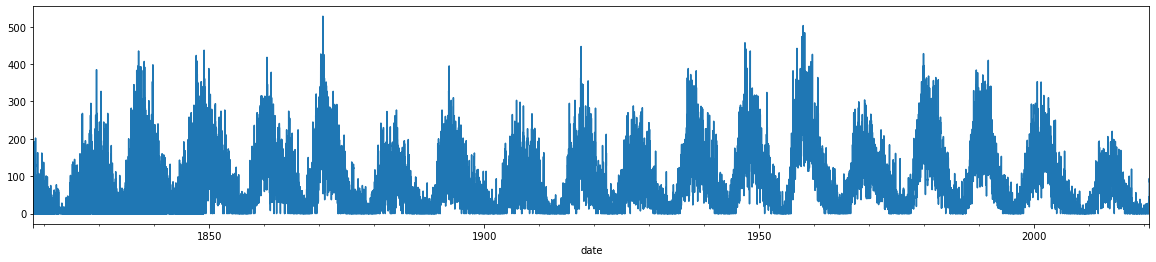

In [40]:
df.total_sunspot_number.plot(figsize=(20,4))

## Preprocessing

Total number of sunspot = -1 means that there are no calculation on that particular day.  We remove them and replace by value from the previous day.

In [41]:
df.total_sunspot_number = np.where((df.total_sunspot_number == -1), np.NAN, df.total_sunspot_number)
df.dropna(axis=0,inplace=True)
ts  = df.total_sunspot_number.asfreq(freq='d', method='bfill')

<AxesSubplot:xlabel='date'>

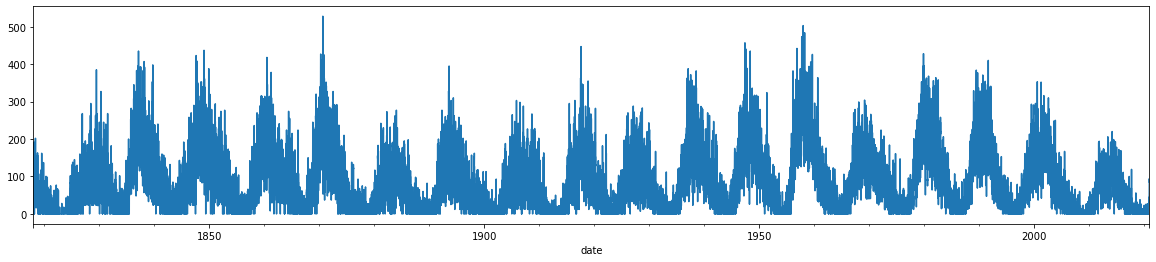

In [42]:
ts.plot(figsize=(20,4))

# Train test split

Before we perform analysis on the data, let us split the data into training set and test set.

In [43]:
train_set, test_set= np.split(ts, [int(.70 *len(ts))])

In [44]:
train_set

date
1818-01-08     65.0
1818-01-09     37.0
1818-01-10     37.0
1818-01-11     37.0
1818-01-12     37.0
              ...  
1960-01-13    153.0
1960-01-14    167.0
1960-01-15    171.0
1960-01-16    169.0
1960-01-17    166.0
Freq: D, Name: total_sunspot_number, Length: 51874, dtype: float64

In [45]:
test_set

date
1960-01-18    146.0
1960-01-19    123.0
1960-01-20    133.0
1960-01-21    153.0
1960-01-22    190.0
              ...  
2020-11-26     57.0
2020-11-27     75.0
2020-11-28     84.0
2020-11-29     94.0
2020-11-30     85.0
Freq: D, Name: total_sunspot_number, Length: 22233, dtype: float64

## Analysis

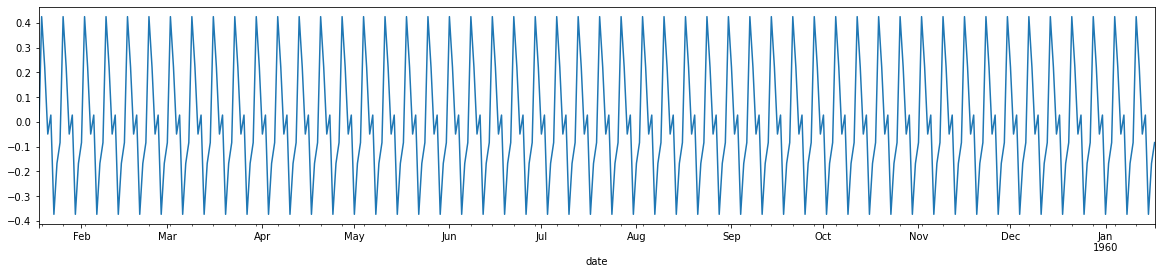

In [46]:
result = seasonal_decompose(train_set, model='additive')
result.seasonal[-365:].plot(figsize=(20, 4))
plt.show()

## Dataset

In [47]:
from torch.utils.data import Dataset, DataLoader

In [48]:
class SunspotDataSet(Dataset):
    def __init__(self, data, input_window_size, num_future):
        self.data = torch.Tensor(data)
        self.input_window_size = input_window_size
        self.num_future = num_future
    
    def __len__(self):
        return len(self.data) - self.input_window_size - self.num_future
    
    def __getitem__(self, idx):
        X = self.data[idx:idx + self.input_window_size]
        y = self.data[idx+self.input_window_size:idx + self.input_window_size + self.num_future]
        return X,y
        

In [49]:
window_size = 30
num_futures = 3
batch_size = 10

In [50]:
train_ds = SunspotDataSet(data=train_set, input_window_size = window_size, num_future = num_futures)
test_ds = SunspotDataSet(data=test_set, input_window_size = window_size, num_future = num_futures)

In [51]:
feature, label = train_ds[0]
feature.shape, label.shape

(torch.Size([30]), torch.Size([3]))

In [52]:
for i in range(len(train_ds)):
    feature, label = train_ds[i]
    if feature.shape != torch.Size([window_size]) or label.shape != torch.Size([num_futures]):
        print(f"{i} x: {feature}, \n y:{label}")
        print(f"x_shape: {feature.shape}, \n y_shape:{label.shape}")

In [53]:
train_loader = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, drop_last=True)

## Building a Model

In [54]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_features, num_hidden, batch_size):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
    
    def initHidden(self):
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
        
    def forward(self, seq):
        seq = seq.view(self.batch_size,seq.shape[1], -1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        return out_lstm, hidden

In [55]:
class DecoderRNN(nn.Module):
    def __init__(self, num_hidden, num_output, batch_size):
        super().__init__()
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
        
    def initHidden(self):
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
        
    def forward(self, seq, hidden):
        seq = seq.view(self.batch_size,seq.shape[1], -1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        return out, hidden

In [56]:
class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures, batch_size):
        super().__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures
        self.batch_size = batch_size
        
        self.encoder = EncoderRNN(self.num_features, self.num_hidden, batch_size)
        self.decoder = DecoderRNN(self.num_hidden, self.num_output, batch_size)
    
    def forward(self, seq, prev_y):
        encoder_out, encoder_hidden = self.encoder(seq)
        #placeholder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        prev_hidden = encoder_hidden
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out.reshape(self.batch_size))
        
        targets = torch.stack(targets_ta, dim=1)
        return targets

In [57]:
model = Seq2Seq(1, 50, 1,num_futures, batch_size)

In [58]:
model

Seq2Seq(
  (encoder): EncoderRNN(
    (lstm): LSTM(1, 50, batch_first=True)
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(1, 50, batch_first=True)
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

In [60]:
epochs = 20

for e in range(epochs):
    losses = []
    for i, data in enumerate(train_loader):
        train_features, train_label = data
        optimizer.zero_grad()
        input_features = torch.tensor([train_label[batch_idx][-1].unsqueeze(dim=0) for batch_idx in range(batch_size)]).unsqueeze(dim=1).unsqueeze(dim=1)
        seq_pred = model(train_features, input_features)
        loss = criterion(seq_pred, train_label)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    print(f"Epoch {e} Mean of RMSE per epoch: {torch.mean(torch.sqrt(torch.tensor(losses)))}")

Epoch 0 Mean of RMSE per epoch: 53.73957824707031
Epoch 1 Mean of RMSE per epoch: 34.33350372314453
Epoch 2 Mean of RMSE per epoch: 28.07634925842285
Epoch 3 Mean of RMSE per epoch: 26.39699363708496
Epoch 4 Mean of RMSE per epoch: 25.26340103149414
Epoch 5 Mean of RMSE per epoch: 25.476083755493164
Epoch 6 Mean of RMSE per epoch: 24.80718231201172
Epoch 7 Mean of RMSE per epoch: 24.688884735107422
Epoch 8 Mean of RMSE per epoch: 24.498926162719727
Epoch 9 Mean of RMSE per epoch: 23.441051483154297
Epoch 10 Mean of RMSE per epoch: 23.552143096923828
Epoch 11 Mean of RMSE per epoch: 22.843509674072266
Epoch 12 Mean of RMSE per epoch: 22.2791805267334
Epoch 13 Mean of RMSE per epoch: 22.102312088012695
Epoch 14 Mean of RMSE per epoch: 21.832796096801758
Epoch 15 Mean of RMSE per epoch: 21.602087020874023
Epoch 16 Mean of RMSE per epoch: 22.083106994628906
Epoch 17 Mean of RMSE per epoch: 21.4434757232666
Epoch 18 Mean of RMSE per epoch: 21.382678985595703
Epoch 19 Mean of RMSE per epoch:

In [68]:
model = model.eval()
with torch.no_grad():
    losses = []
    labels = []
    predictions = []
    for i,data in enumerate(test_loader):
        train_features, train_labels = data
        input_features = torch.tensor([train_labels[batch_idx][-1].unsqueeze(dim=0) for batch_idx in range(batch_size)]).unsqueeze(dim=1).unsqueeze(dim=1)
        pred = model(train_features, input_features)
        loss = criterion(pred, train_labels)
        losses.append(loss)
        labels.append(train_labels)
        predictions.append(pred)
    print(torch.mean(torch.sqrt(torch.tensor(losses))))

tensor(17.8931)


In [69]:
labels = torch.cat(labels).cpu().numpy().flatten()
predictions = torch.cat(predictions).cpu().numpy().flatten()

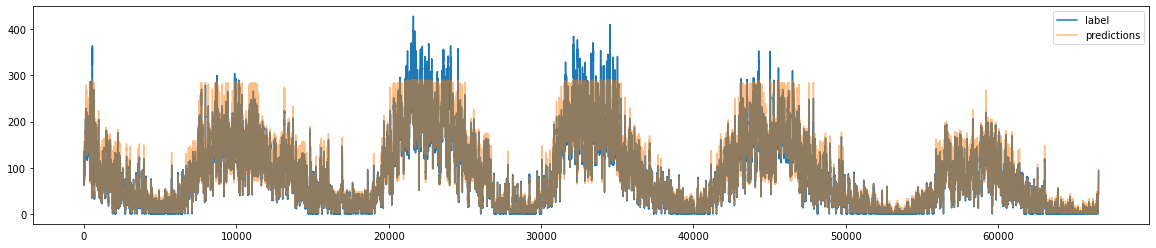

In [70]:
plt.figure(figsize=(20,4))
plt.plot(labels, label="label")
plt.plot(predictions, label='predictions', alpha=0.5)
plt.legend()
plt.show()